**Object Localization Project:**
---
step by step approach: 
---
1) Detect synthetic white shape over black background

2) Detect a cat over a black background

3) Detect a cat over natural background

all data from - https://drive.google.com/drive/folders/1YsxDywjUZi-l_YgzXt__9__eUU-I_6EH?usp=sharing

In [16]:
 %tensorflow_version 2.x
 import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.utils import  plot_model
import matplotlib.pyplot as plt

BATCH_SIZE = 64
EPOCH_SIZE = 64

**First Step** - detect synthetic white shape over black background

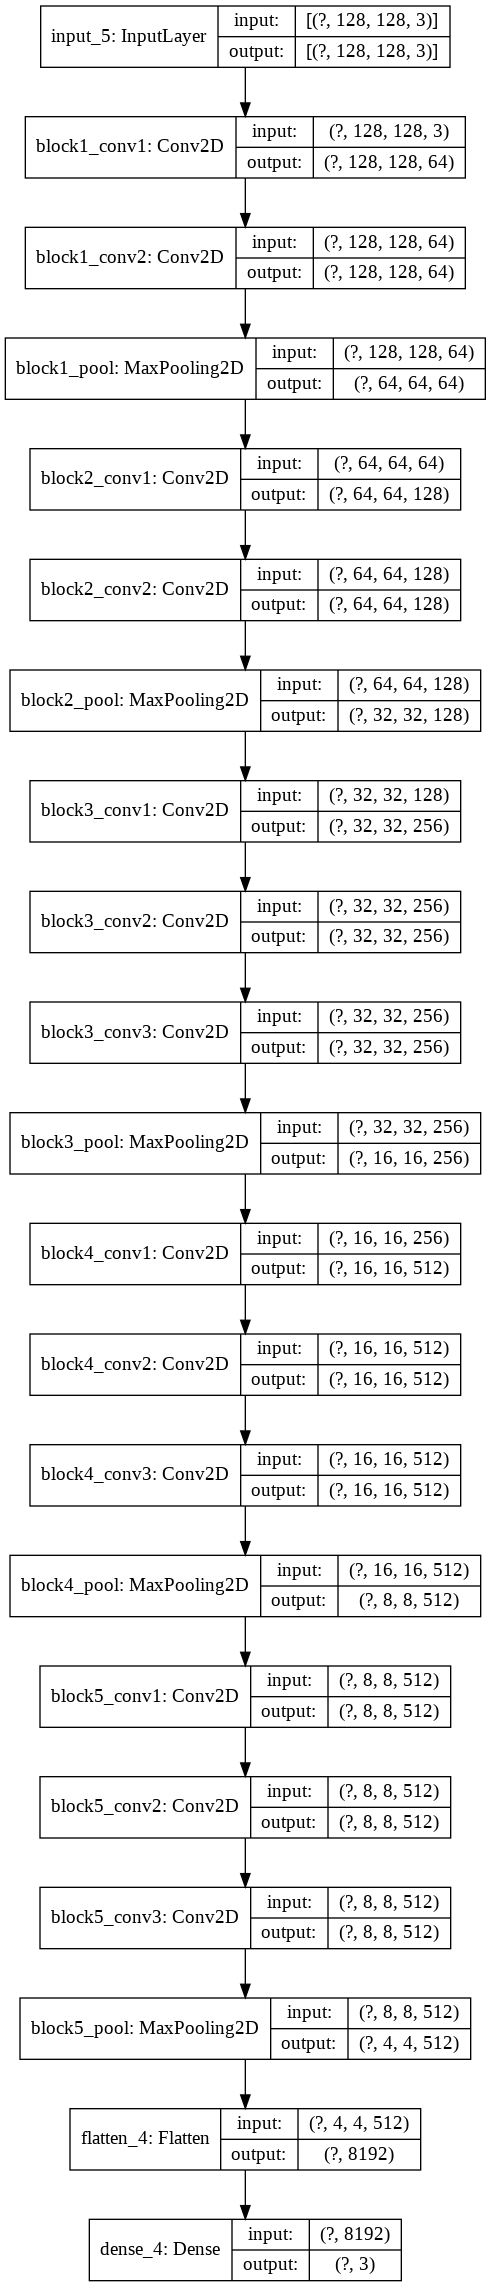

In [18]:
# transfer learning - load pre-trained vgg and replace its head
vgg = tf.keras.applications.VGG16(input_shape=[128, 128, 3], include_top=False, weights='imagenet')
x = Flatten()(vgg.output)
x = Dense(3, activation='sigmoid')(x)
model1 = Model(vgg.input, x)
model1.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001))
# plot the model
plot_model(model1, "first_model.png",show_shapes=True,expand_nested=False)

create a circle-generator

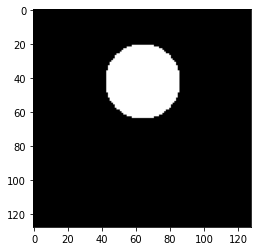

In [3]:
from matplotlib.patches import Circle

def synthetic_gen(batch_size=64):
  # enable generating infinite amount of batches
  while True:
      # generate black images in the wanted size
      X = np.zeros((batch_size, 128, 128, 3))
      Y = np.zeros((batch_size, 3))
      # fill each image
      for i in range(batch_size):
        x = np.random.randint(8,120)
        y = np.random.randint(8,120)
        a = min(128 - max(x,y), min(x,y))
        r = np.random.randint(4,a)
        for x_i in range(128):
          for y_i in range(128):
            if ((x_i - x)**2) + ((y_i - y)**2) < r**2:
              X[i, x_i, y_i,:] = 1
        Y[i,0] = (x-r)/128.
        Y[i,1] = (y-r)/128.
        Y[i,2] = 2*r / 128.
      yield X, Y

# sanity check - plot the images
x,y = next(synthetic_gen())
plt.imshow(x[0])

train the model

In [4]:
# needs steps per epoch since the generator is infinite
model1.fit_generator(synthetic_gen(),steps_per_epoch=EPOCH_SIZE,epochs=5)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
64/64 [==============================] - 50s 774ms/step - loss: 0.5741
Epoch 2/5
64/64 [==============================] - 50s 787ms/step - loss: 0.4931
Epoch 3/5
64/64 [==============================] - 51s 792ms/step - loss: 0.4936
Epoch 4/5
64/64 [==============================] - 50s 787ms/step - loss: 0.4922
Epoch 5/5
64/64 [==============================] - 50s 788ms/step - loss: 0.4910


predict results

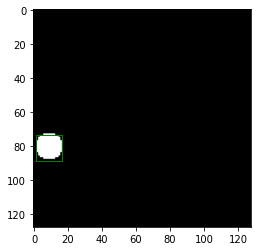

In [5]:
from matplotlib.patches import Rectangle

# given image and a label, plots the image + rectangle
def plot_pred(img,p):
  fig, ax = plt.subplots(1)
  ax.imshow(img)
  rect = Rectangle(xy=(p[1]*128,p[0]*128),width=p[2]*128, height=p[2]*128, linewidth=1,edgecolor='g',facecolor='none')
  ax.add_patch(rect)
  plt.show()


# generate new image
x, _ = next(synthetic_gen())
# predict
pred = model1.predict(x)
# examine 1 image
im = x[0]
p = pred[0]
plot_pred(im,p)


**Second Step**-detect a cat over a black background

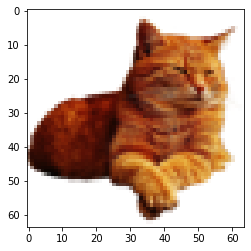

(64, 64, 4)

In [6]:
from PIL import Image

cat_pil = Image.open("cat.png")
cat_pil = cat_pil.resize((64,64))
cat = np.asarray(cat_pil)
plt.imshow(cat)
plt.show()


cat.shape

create a cat generator

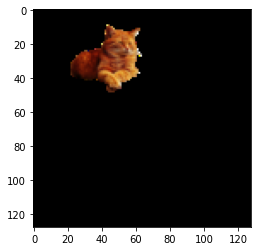

In [7]:
from matplotlib.patches import Circle

def cat_gen(batch_size=64):
  # enable generating infinite amount of batches
  while True:
      # generate black images in the wanted size
      X = np.zeros((batch_size, 128, 128, 3))
      Y = np.zeros((batch_size, 3))
      # fill each image
      for i in range(batch_size):
        # resize the cat
        size = np.random.randint(32,64)
        temp_cat = cat_pil.resize((size,size))
        cat = np.asarray(temp_cat) / 255.
        cat_x, cat_y, _ = cat.shape
        bg = Image.new('RGB', (128, 128))

        x1 = np.random.randint(1,128 - cat_x)
        y1 = np.random.randint(1,128 - cat_y)
        h = cat_x
        w = cat_y

        bg.paste(temp_cat, (x1, y1))
        cat = np.asarray(bg) / 255.
        X[i] = cat

        Y[i,0] = x1/128.
        Y[i,1] = y1/128.
        Y[i,2] = cat_x / 128.
      yield X, Y

# sanity check - plot the images
x,y = next(cat_gen())
plt.imshow(x[0])

create a model

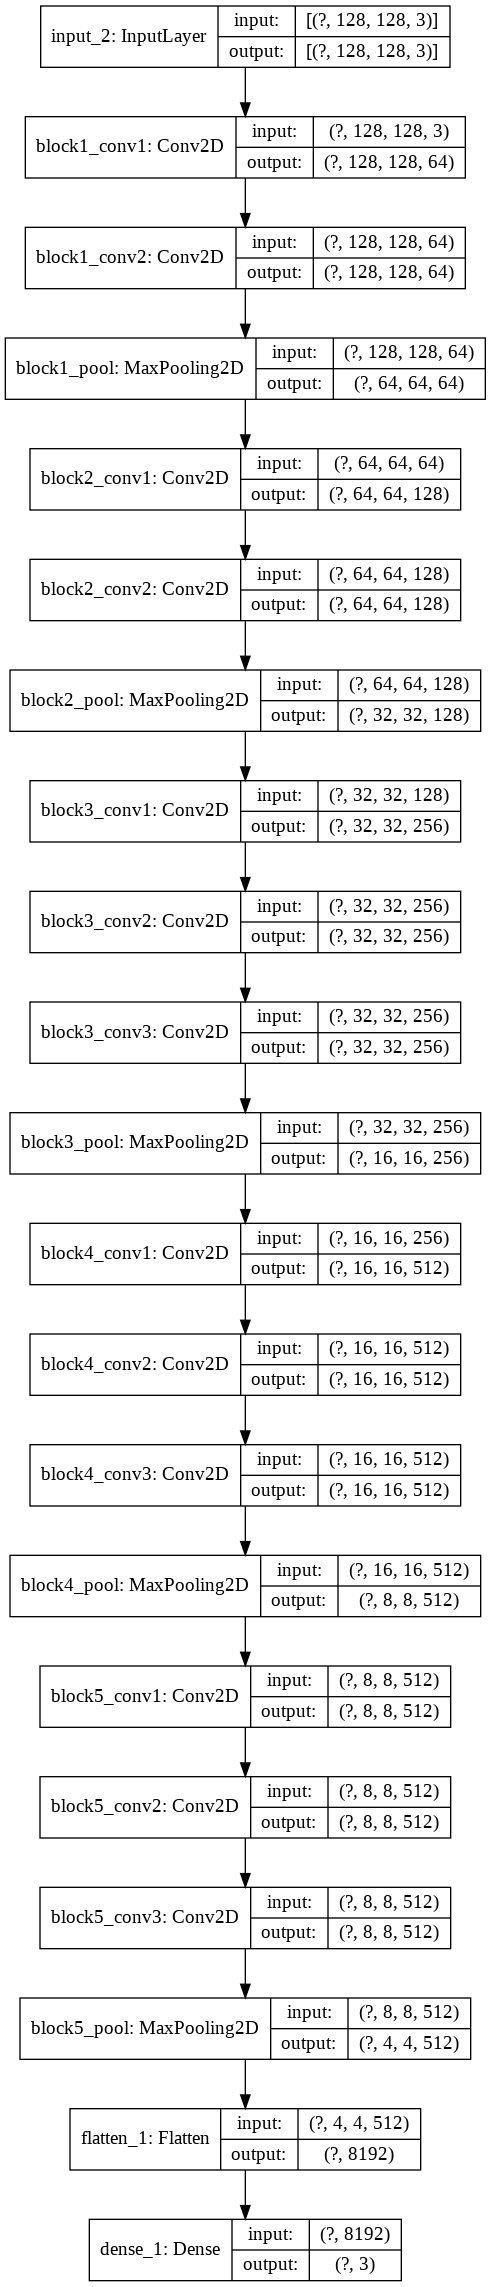

In [8]:
# transfer learning - load pre-trained vgg and replace its head
vgg = tf.keras.applications.VGG16(input_shape=[128, 128, 3], include_top=False, weights='imagenet')
x = Flatten()(vgg.output)
x = Dense(3, activation='sigmoid')(x)
model2 = Model(vgg.input, x)
model2.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001))
# plot the model
plot_model(model2, "second_model.png",show_shapes=True)

train

In [9]:
# needs steps per epoch since the generator is infinite
model2.fit_generator(cat_gen(),steps_per_epoch=EPOCH_SIZE,epochs=5)

Epoch 1/5
64/64 [==============================] - 9s 143ms/step - loss: 0.6948
Epoch 2/5
64/64 [==============================] - 9s 143ms/step - loss: 0.5787
Epoch 3/5
64/64 [==============================] - 9s 143ms/step - loss: 0.5765
Epoch 4/5
64/64 [==============================] - 9s 143ms/step - loss: 0.5755
Epoch 5/5
64/64 [==============================] - 9s 143ms/step - loss: 0.5746


predict results

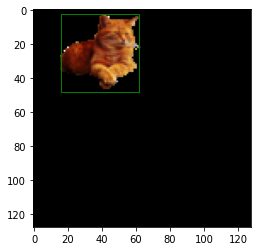

In [10]:
from matplotlib.patches import Rectangle

# given image and a label, plots the image + rectangle
def plot_pred(img,p):
  fig, ax = plt.subplots(1)
  ax.imshow(img)
  rect = Rectangle(xy=(p[0]*128,p[1]*128),width=p[2]*128, height=p[2]*128, linewidth=1,edgecolor='g',facecolor='none')
  ax.add_patch(rect)
  plt.show()


# generate new image
x, _ = next(cat_gen())
# predict
pred = model2.predict(x)
# examine 1 image
im = x[0]
p = pred[0]
plot_pred(im,p)

**Third Step** - detect a cat over natural background

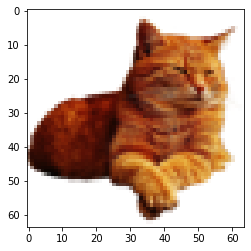

(64, 64, 4)

In [11]:
from PIL import Image

cat_pil = Image.open("cat.png")
cat_pil = cat_pil.resize((64,64))
cat = np.asarray(cat_pil)
plt.imshow(cat)
plt.show()


cat.shape

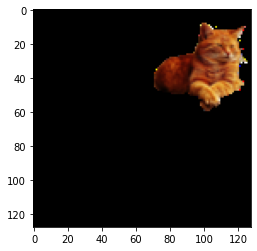

In [12]:
from matplotlib.patches import Circle

def natural_cat_gen(batch_size=64):
  # enable generating infinite amount of batches
  while True:
      # generate black images in the wanted size
      X = np.zeros((batch_size, 128, 128, 3))
      Y = np.zeros((batch_size, 3))
      # fill each image
      for i in range(batch_size):
        # resize the cat
        size = np.random.randint(32,64)
        temp_cat = cat_pil.resize((size,size))
        cat = np.asarray(temp_cat) / 255.
        cat_x, cat_y, _ = cat.shape
        # background image
        bg_name = f'bg{np.random.randint(1,4)}.jpg'
        bg = Image.open(bg_name)

        x1 = np.random.randint(1,128 - cat_x)
        y1 = np.random.randint(1,128 - cat_y)
        h = cat_x
        w = cat_y

        bg.paste(temp_cat, (x1, y1),mask=temp_cat)
        cat = np.asarray(bg) / 255.
        X[i] = cat

        Y[i,0] = x1/128.
        Y[i,1] = y1/128.
        Y[i,2] = cat_x / 128.
      yield X, Y

# sanity check - plot the images
x,y = next(cat_gen())
plt.imshow(x[0])

create model3

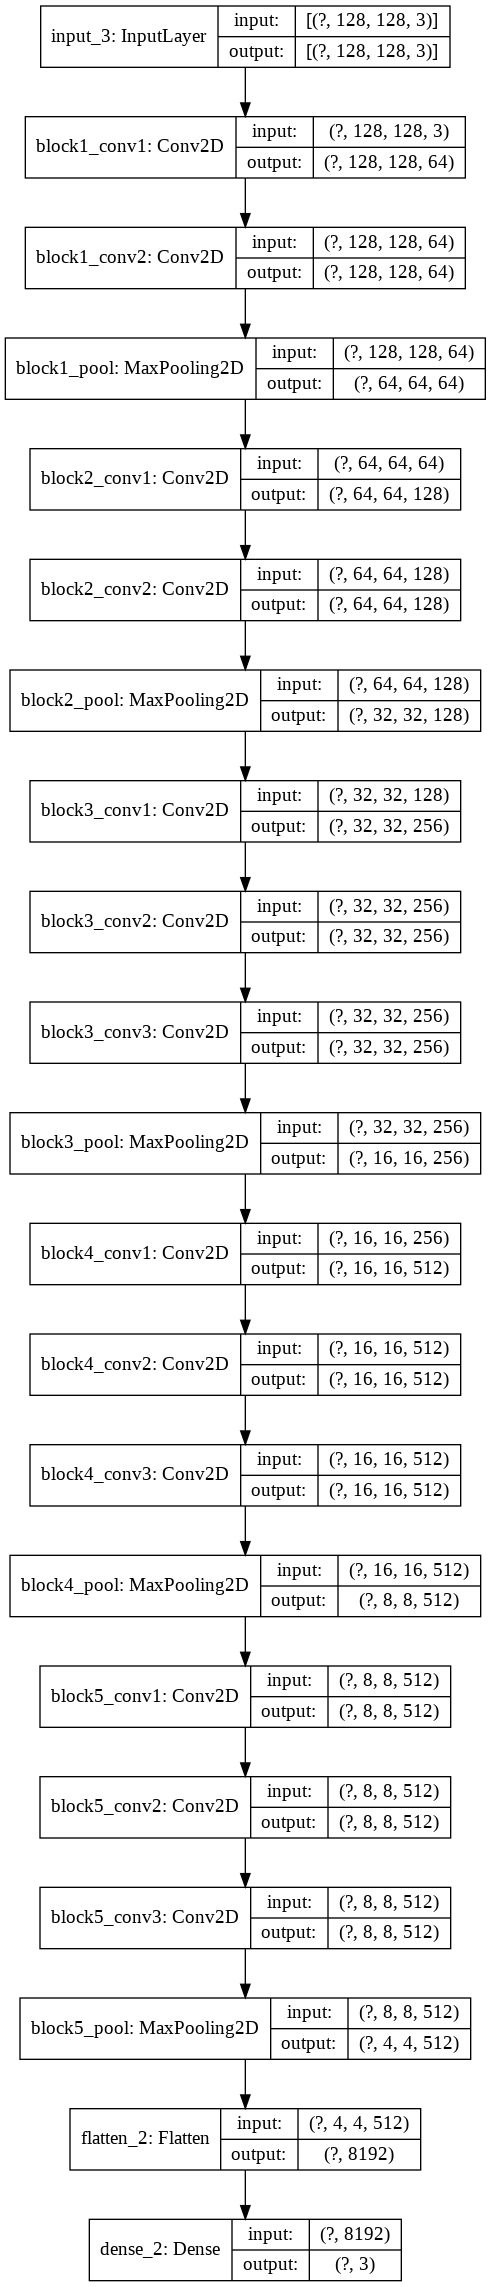

In [13]:
# transfer learning - load pre-trained vgg and replace its head
vgg = tf.keras.applications.VGG16(input_shape=[128, 128, 3], include_top=False, weights='imagenet')
x = Flatten()(vgg.output)
x = Dense(3, activation='sigmoid')(x)
model3 = Model(vgg.input, x)
model3.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001))
# plot the model
plot_model(model3, "third_model.png",show_shapes=True)

train model3

In [14]:
# needs steps per epoch since the generator is infinite
model3.fit_generator(natural_cat_gen(),steps_per_epoch=EPOCH_SIZE,epochs=5)

Epoch 1/5
64/64 [==============================] - 9s 142ms/step - loss: 0.6751
Epoch 2/5
64/64 [==============================] - 9s 143ms/step - loss: 0.5999
Epoch 3/5
64/64 [==============================] - 9s 143ms/step - loss: 0.5765
Epoch 4/5
64/64 [==============================] - 9s 141ms/step - loss: 0.5735
Epoch 5/5
64/64 [==============================] - 9s 142ms/step - loss: 0.5737


examine results

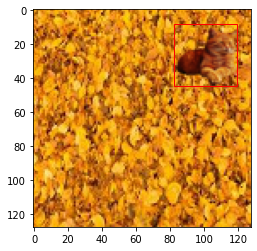

In [15]:
from matplotlib.patches import Rectangle

# given image and a label, plots the image + rectangle
def plot_pred(img,p):
  fig, ax = plt.subplots(1)
  ax.imshow(img)
  rect = Rectangle(xy=(p[0]*128,p[1]*128),width=p[2]*128, height=p[2]*128, linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)
  plt.show()


# generate new image
x, _ = next(natural_cat_gen())
# predict
pred = model3.predict(x)
# examine 1 image
im = x[0]
p = pred[0]
plot_pred(im,p)